<a href="https://colab.research.google.com/github/DamodaraBarbosa/machine_learning_studies/blob/main/laptops_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install categorical-encoding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.3/618.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.9 MB/s eta 0:00:00


Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format) # avoid scientific notation.

# 1. Load of dataset

In [4]:
# Instance of train_data:

train_data = pd.read_csv('/content/drive/MyDrive/Kaggle/laptops_train.csv')

train_data.head(2)

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48


In [5]:
# Instance of test_data:

test_data = pd.read_csv('/content/drive/MyDrive/Kaggle/laptops_test.csv')

test_data.head(2)

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",1366x768,Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,10,2.04kg,5148468.00
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,15552108.00


In [6]:
# Dataframe with train data and test data:

df = pd.concat([train_data, test_data], ignore_index= True, join= 'inner') # the parameter ignore index reset the index of the generated dataframe.

df.head(2)

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48


# 2. About the data

From Kaggle: https://www.kaggle.com/datasets/arnabchaki/laptop-price-prediction

> What Factors Affect Laptop Computer Prices?
>
> Several different factors can affect laptop computer prices. These factors include the brand of computer and the number of options and add-ons included in the computer package. In addition, the amount of memory and the speed of the processor can also affect pricing. Though less common, some consumers spend additional money to purchase a computer based on the overall “look” and design of the system.
>
> In many cases, name brand computers are more expensive than generic versions. This price increase often has more to do with name recognition than any actual superiority of the product. One major difference between name brand and generic systems is that in most cases, name brand computers offer better warranties than generic versions. Having the option of returning a computer that is malfunctioning is often enough of an incentive to encourage many consumers to spend more money.
>
> Functionality is an important factor in determining laptop computer prices. A computer with more memory often performs better for a longer time than a computer with less memory. In addition, hard drive space is also crucial, and the size of the hard drive usually affects pricing. Many consumers may also look for digital video drivers and other types of recording devices that may affect the laptop computer prices.
>
> Most computers come with some software pre-installed. In most cases, the more software that is installed on a computer, the more expensive it is. This is especially true if the installed programs are from well-established and recognizable software publishers. Those considering purchasing a new laptop computer should be aware that many of the pre-installed programs may be trial versions only, and will expire within a certain time period. In order to keep the programs, a code will need to be purchased, and then a permanent version of the software can be downloaded.
>
> -Many consumers who are purchasing a new computer are buying an entire package. In addition to the computer itself, these systems typically include a monitor, keyboard, and mouse. Some packages may even include a printer or digital camera. The number of extras included in a computer package usually affects laptop computer prices.
Some industry leaders in computer manufacturing make it a selling point to offer computers in sleek styling and in a variety of colors. They may also offer unusual or contemporary system design. Though this is less important to many consumers, for those who do value “looks,” this type of system may be well worth the extra cost.

# 3. Information about the dataframe

## 3.1. Dataframe's shape

In [7]:
train_data.shape

(977, 13)

> 13 columns and 977 rows for `train_data` dataframe.

In [8]:
test_data.shape

(325, 13)

> 13 columns and 977 rows for `test_data` dataframe.

In [9]:
df.shape

(1302, 13)

> 13 columns and 1302 rows for `df` dataframe (`train_data` + `test_data` dataframes).

## 3.2. Data types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              1302 non-null   object 
 1   Model Name                1302 non-null   object 
 2   Category                  1302 non-null   object 
 3   Screen Size               1302 non-null   object 
 4   Screen                    1302 non-null   object 
 5   CPU                       1302 non-null   object 
 6   RAM                       1302 non-null   object 
 7    Storage                  1302 non-null   object 
 8   GPU                       1302 non-null   object 
 9   Operating System          1302 non-null   object 
 10  Operating System Version  1132 non-null   object 
 11  Weight                    1302 non-null   object 
 12  Price                     1302 non-null   float64
dtypes: float64(1), object(12)
memory usage: 132.4+ KB


## 3.3. Missing values

In [11]:
df.isna().sum()

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
 Storage                      0
GPU                           0
Operating System              0
Operating System Version    170
Weight                        0
Price                         0
dtype: int64

> The only column with missing values is `Operating System Version`. These values ​​account for about 13% of the data in that column.

# 4. Data processing

## 4.1. Columns rename

The columns are all renamed so that they are easier to access.

In [12]:
df = df.rename(
    {'Manufacturer': 'manufacturer', 'Model Name': 'model_name', 'Category': 'category', 'Screen Size': 'screen_size',
     'Screen': 'screen', 'CPU': 'cpu', 'RAM': 'ram', ' Storage': 'storage', 'GPU': 'gpu', 'Operating System': 'operating_system',
     'Operating System Version': 'operating_system_version', 'Weight': 'weight', 'Price': 'price'}, axis= 1
)

In [13]:
df.head(2)

,manufacturer,model_name,category,screen_size,screen,cpu,ram,storage,gpu,operating_system,operating_system_version,weight,price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48


## 4.2. `screen_size` to float

In [14]:
# Remove of " character:

df['screen_size'] = df['screen_size'].str.replace('"', '')

# Convert of data for float type:

df['screen_size'] = df['screen_size'].astype(float)

## 4.3. `ram` to integer

In [15]:
# Remove of "GB" characters:

df['ram'] = df['ram'].str.replace('GB', '')

# Convert of data for integer type:

df['ram'] = df['ram'].astype(int)

## 4.4. `weight` to float

In [16]:
# Remove of "kg" character:

df['weight'] = df['weight'].str.replace('kg', '')

There is a single line that contains the value 4s, that is, it does not bring any information about the weight of the notebook.

In [17]:
# The line with that value is searched and its index is determined:

not_weight_index = df.query('weight == "4s"').index[0]

# This specific line is dropped:

df = df.drop(not_weight_index, axis= 0)


In [18]:
# The weight values are converted to float type:

df['weight'] = df['weight'].astype(float)

## 4.5. Fill of `operating_system_version` with mode

The `operating_system_version` column contains missing data that cannot be disregarded. Since these are categorical data, you can fill in with the mode.

In [19]:
system_version_mode = df['operating_system_version'].mode()[0]
system_version_mode

'10'

In [20]:
# NaN is replaced by the mode of the column data:

df['operating_system_version'] = df['operating_system_version'].replace(np.NaN, system_version_mode)

In [21]:
df['operating_system_version'].unique()

array(['10', 'X', '10 S', '7'], dtype=object)

> Checks that NaN is no longer part of the column `operating_system_version` data.

In [22]:
df.dtypes

manufacturer                 object
model_name                   object
category                     object
screen_size                 float64
screen                       object
cpu                          object
ram                           int64
storage                      object
gpu                          object
operating_system             object
operating_system_version     object
weight                      float64
price                       float64
dtype: object

# 5. Exploratory data analysis

## 5.1. `manufacturer` column

In [23]:
df['manufacturer'].unique()

array(['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI',
       'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer',
       'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'], dtype=object)

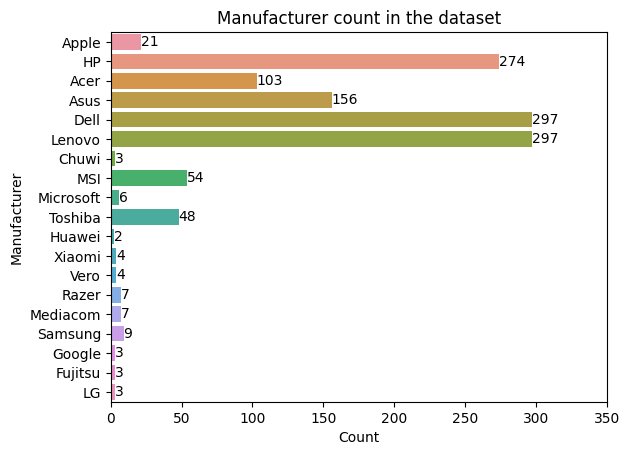

In [24]:
# Countplot of manufacturer column data:

ax = sns.countplot(data= df, y= 'manufacturer')
ax.set_title('Manufacturer count in the dataset')

# Set a bar label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Manufacturer')
ax.set_xlabel('Count')
ax.set_xlim([0, 350]) # set the range of limit for x-axis.
plt.show()

> * The manufacturers that stand out in the data set are: Dell, Lenovo, Asus, Acer and HP.
> * Dell and Lenovo have the same dataset frequency.

## 5.2. `model_name` column

In [25]:
df['model_name'].nunique()

616

> There are 616 different models of laptops from different manufacturers in the dataset.

In [26]:
most_frequent_models = df.value_counts('model_name', ascending= False).head(10)

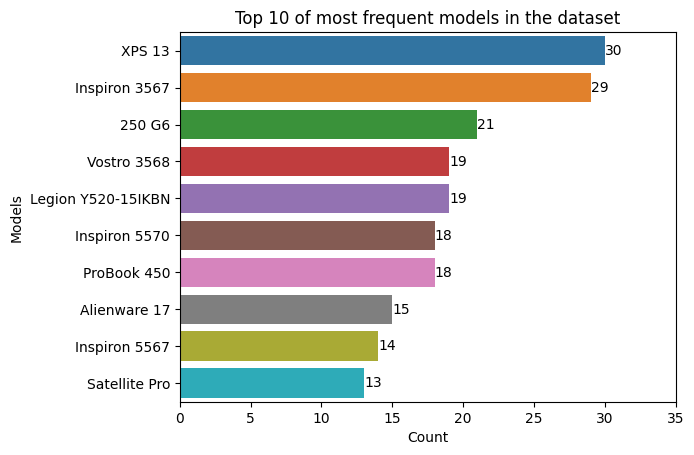

In [27]:
# Barplot of the most frequent models in model_name column data:

ax = sns.barplot(y= most_frequent_models.keys(), x= most_frequent_models.values)
ax.set_title('Top 10 of most frequent models in the dataset')

# Set a bar label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Models')
ax.set_xlabel('Count')
ax.set_xlim([0, 35]) # set the range of limit for x-axis.
plt.show()

## 5.3. `category` column

In [28]:
df['category'].unique()

array(['Ultrabook', 'Notebook', 'Netbook', 'Gaming', '2 in 1 Convertible',
       'Workstation'], dtype=object)

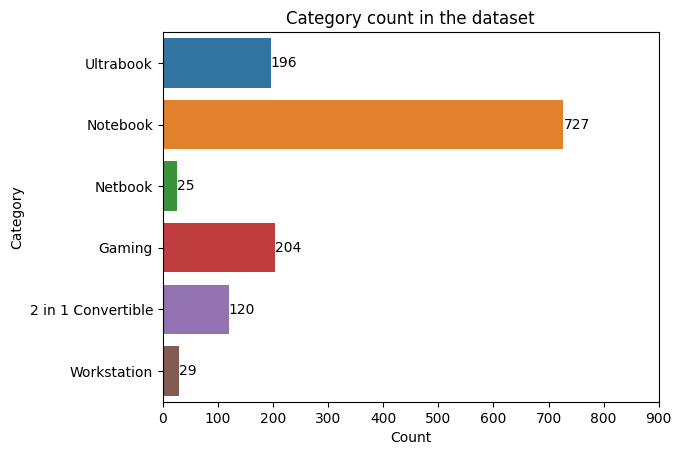

In [29]:
# Countplot of category column data:

ax = sns.countplot(data= df, y= 'category')
ax.set_title('Category count in the dataset')

# Set a bar label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Category')
ax.set_xlabel('Count')
ax.set_xlim([0, 900]) # set the range of limit for x-axis.
plt.show()

> * Most of the laptops in the dataset are standard laptops.
> * Ultrabooks and gaming notebooks are also highlighted.

## 5.4. `screen_size` column

In [30]:
df['screen_size'].describe()

count   1301.00
mean      15.01
std        1.43
min       10.10
25%       14.00
50%       15.60
75%       15.60
max       18.40
Name: screen_size, dtype: float64

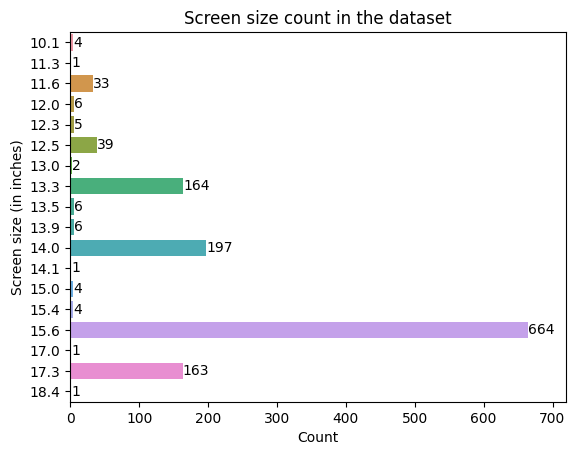

In [31]:
# Countplot of screen_size column data:

ax = sns.countplot(data= df, y= 'screen_size')
ax.set_title('Screen size count in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Screen size (in inches)')
ax.set_xlabel('Count')
ax.set_xlim([0, 720]) # set the range of limit for x-axis.
plt.show()

## 5.5. `screen` column

In [32]:
df['screen'].nunique()

40

In [33]:
most_frequent_screens = df['screen'].value_counts(ascending= False).head(10)

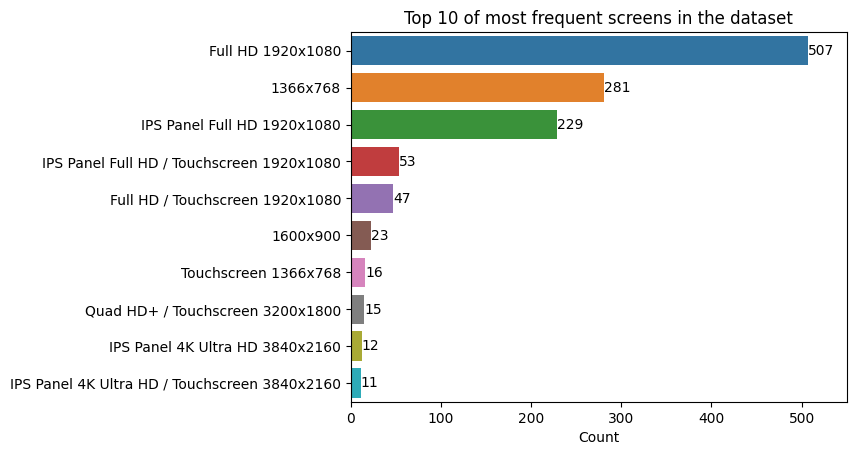

In [34]:
# Barplot of the most frequent screens:

ax = sns.barplot(y= most_frequent_screens.keys(), x= most_frequent_screens.values)
ax.set_title('Top 10 of most frequent screens in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_xlabel('Count')
ax.set_xlim([0, 550]) # set the range of limit for x-axis.
plt.show()

> * In general, the most popular screens are those with Full HD resolution.

## 5.6. `cpu` column

In [35]:
df['cpu'].nunique()

118

In [36]:
most_frequent_cpu = df['cpu'].value_counts(ascending= False).head(10)

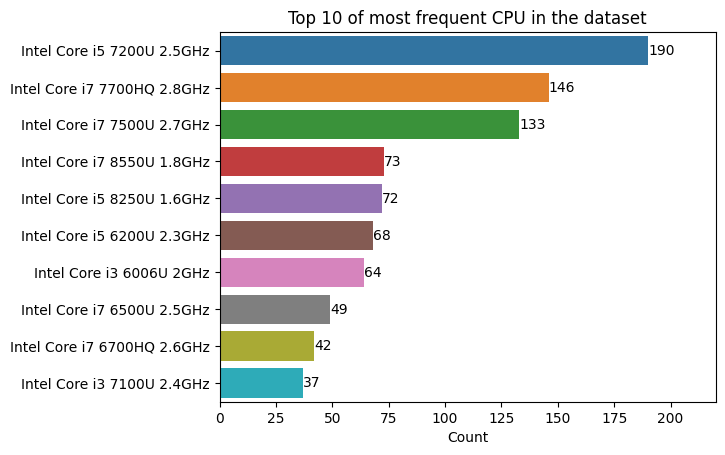

In [37]:
# Barplot of the most frequent screens:

ax = sns.barplot(y= most_frequent_cpu.keys(), x= most_frequent_cpu.values)
ax.set_title('Top 10 of most frequent CPU in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_xlabel('Count')
ax.set_xlim([0, 220]) # set the range of limit for x-axis.
plt.show()

> The most popular CPUs are all Intel branded models.

## 5.7. `ram` column

In [38]:
df['ram'].describe()

count   1301.00
mean       8.37
std        5.08
min        2.00
25%        4.00
50%        8.00
75%        8.00
max       64.00
Name: ram, dtype: float64

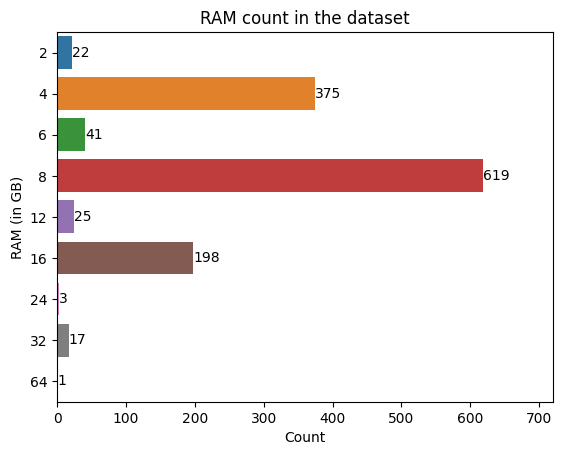

In [39]:
# Countplot of screen_size column data:

ax = sns.countplot(data= df, y= 'ram')
ax.set_title('RAM count in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('RAM (in GB)')
ax.set_xlabel('Count')
ax.set_xlim([0, 720]) # set the range of limit for x-axis.
plt.show()

## 5.8. `storage` column

In [40]:
df['storage'].nunique()

38

> There are 38 different storage types in the dataset.

In [41]:
most_frequent_storage = df['storage'].value_counts(ascending= False).head(10)

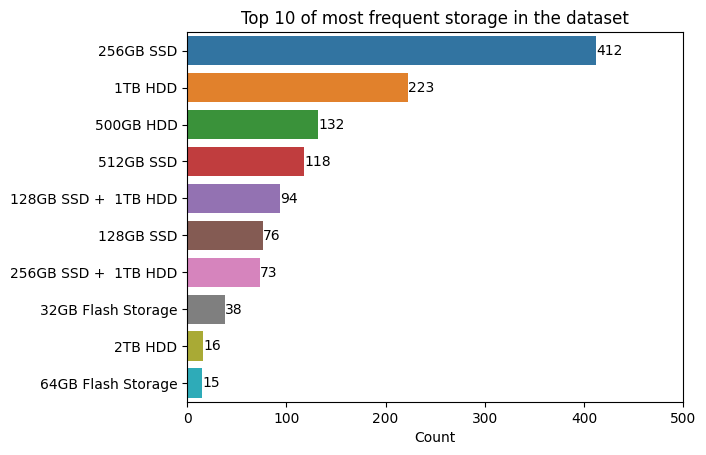

In [42]:
# Barplot of the most frequent screens:

ax = sns.barplot(y= most_frequent_storage.keys(), x= most_frequent_storage.values)
ax.set_title('Top 10 of most frequent storage in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_xlabel('Count')
ax.set_xlim([0, 500]) # set the range of limit for x-axis.
plt.show()

##  5.9. `gpu` column

In [43]:
df['gpu'].nunique()

110

> There are 110 different GPU models in the dataset.

In [44]:
most_frequent_gpu = df['gpu'].value_counts(ascending= False).head(10)

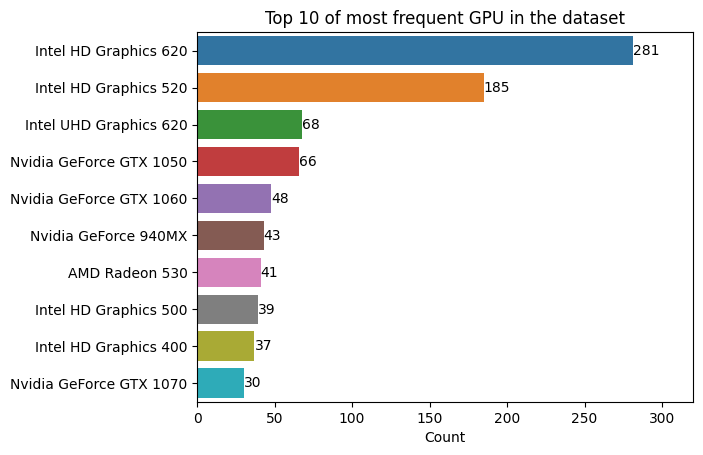

In [45]:
# Barplot of the most frequent screens:

ax = sns.barplot(y= most_frequent_gpu.keys(), x= most_frequent_gpu.values)
ax.set_title('Top 10 of most frequent GPU in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_xlabel('Count')
ax.set_xlim([0, 320]) # set the range of limit for x-axis.
plt.show()

> The most popular GPUs in the dataset are Intel and Nvidia respectively.

5.10. `operatin_system` column

In [46]:
df['operating_system'].unique()

array(['macOS', 'No OS', 'Windows', 'Mac OS', 'Linux', 'Android',
       'Chrome OS'], dtype=object)

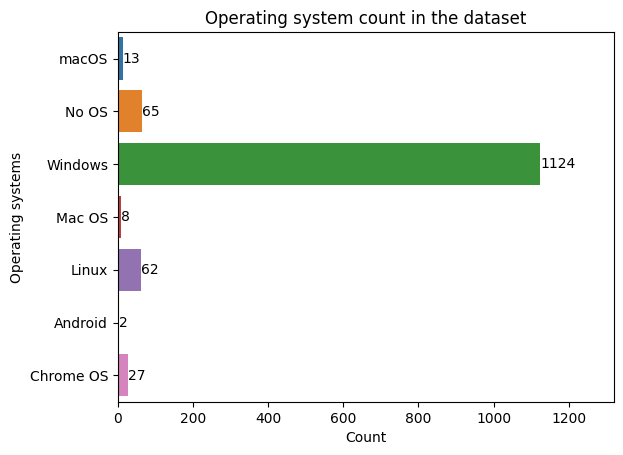

In [47]:
# Countplot of screen_size column data:

ax = sns.countplot(data= df, y= 'operating_system')
ax.set_title('Operating system count in the dataset')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Operating systems')
ax.set_xlabel('Count')
ax.set_xlim([0, 1320]) # set the range of limit for x-axis.
plt.show()

> Most laptops have Windows as their operating system.

## 5.10. `weight` column

In [48]:
df['weight'].describe()

count   1301.00
mean       2.04
std        0.66
min        0.69
25%        1.50
50%        2.04
75%        2.30
max        4.70
Name: weight, dtype: float64

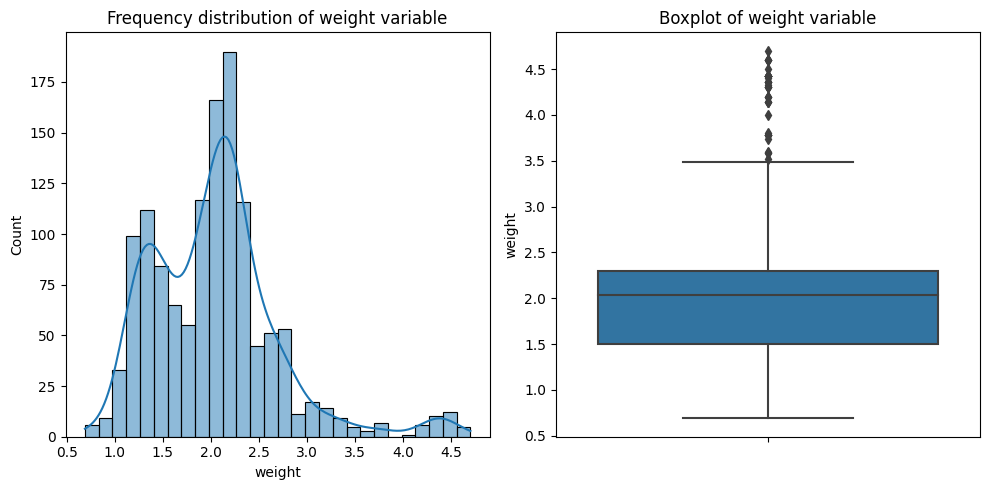

In [49]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(data= df, x= 'weight', kde= True, ax= ax[0])
ax1.set_title('Frequency distribution of weight variable')
ax2 = sns.boxplot(data=  df, y= 'weight', ax= ax[1])
ax2.set_title('Boxplot of weight variable')
plt.tight_layout()
plt.show()

## 5.10. `price` column

In [50]:
df['price'].describe()

count       1301.00
mean     9988068.18
std      6218059.43
min      1547208.00
25%      5326308.00
50%      8687484.00
75%     13220358.84
max     54232308.00
Name: price, dtype: float64

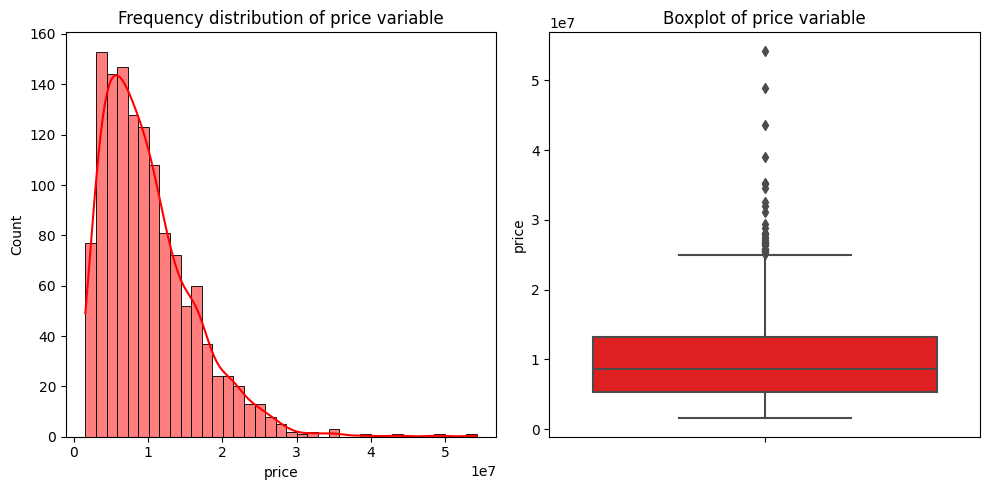

In [51]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(data= df, x= 'price', kde= True, color= 'r', ax= ax[0])
ax1.set_title('Frequency distribution of price variable')
ax2 = sns.boxplot(data=  df, y= 'price', color= 'r', ax= ax[1])
ax2.set_title('Boxplot of price variable')
plt.tight_layout()
plt.show()

### Which category have the most expensive laptops?

In [52]:
df.groupby('category')['price'].agg(['mean', 'median', 'std'])

,mean,median,std
category,,,
2 in 1 Convertible,11364835.56,10661508.00,5460991.19
Gaming,15427403.37,13297096.80,7242930.77
Netbook,5657374.94,3023280.00,5168794.20
Notebook,6954243.13,6144372.00,3947801.96
Ultrabook,13766864.34,13329108.00,4351766.64
Workstation,20276951.92,18361090.80,6336826.28


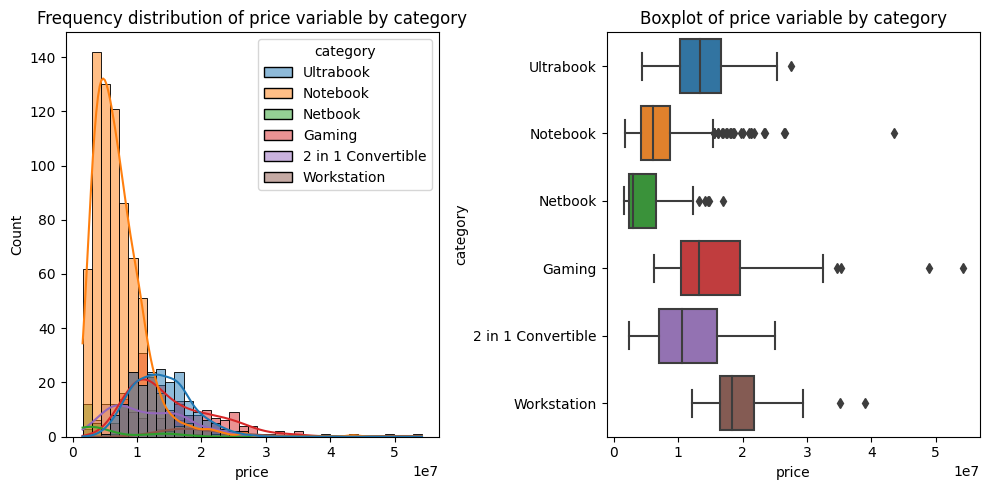

In [53]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(data= df, x= 'price', kde= True, hue= 'category', ax= ax[0])
ax1.set_title('Frequency distribution of price variable by category')
ax2 = sns.boxplot(data=  df, x= 'price', y= 'category', ax= ax[1])
ax2.set_title('Boxplot of price variable by category')
plt.tight_layout()
plt.show()

> When analyzing the table and graphs, it is noticed that laptops in the Workstation category have the highest median price.

However, the median price values ​​between the Gaming and Ultrabook categories are very close. Since such data do not follow a normal distribution, a non-parametric Mann-Whitney test can be performed to compare the values.

In [54]:
# Samples:

gaming = df.query('category == "Gaming"')['price']
ultrabook = df.query('category == "Ultrabook"')['price']

$md_1$ → Gaming laptop price median

$md_2$ → Ultrabook laptop price median

> $H_0: md_1 = md_2$
>
> $H_1: md_1 \neq md_2 $

In [55]:
stats, pvalue = mannwhitneyu(gaming, ultrabook, alternative= 'two-sided')

In [56]:
print(f'Stats = {stats}')
print(f'Pvalue = {pvalue}')

Stats = 21317.5
Pvalue = 0.25166718890453654


$H_0$ hypothesis is rejected if $pvalue \leq α$.  Assuming that the significance level ($α$) is 5% (0.05):

In [57]:
pvalue <= 0.05

False

> There is no statistical evidence to reject the $H_0$ hypothesis. Therefore, the median price of gaming laptops and ultrabook laptops is assumed to be the same.

## 5.11. Pairplot between variables

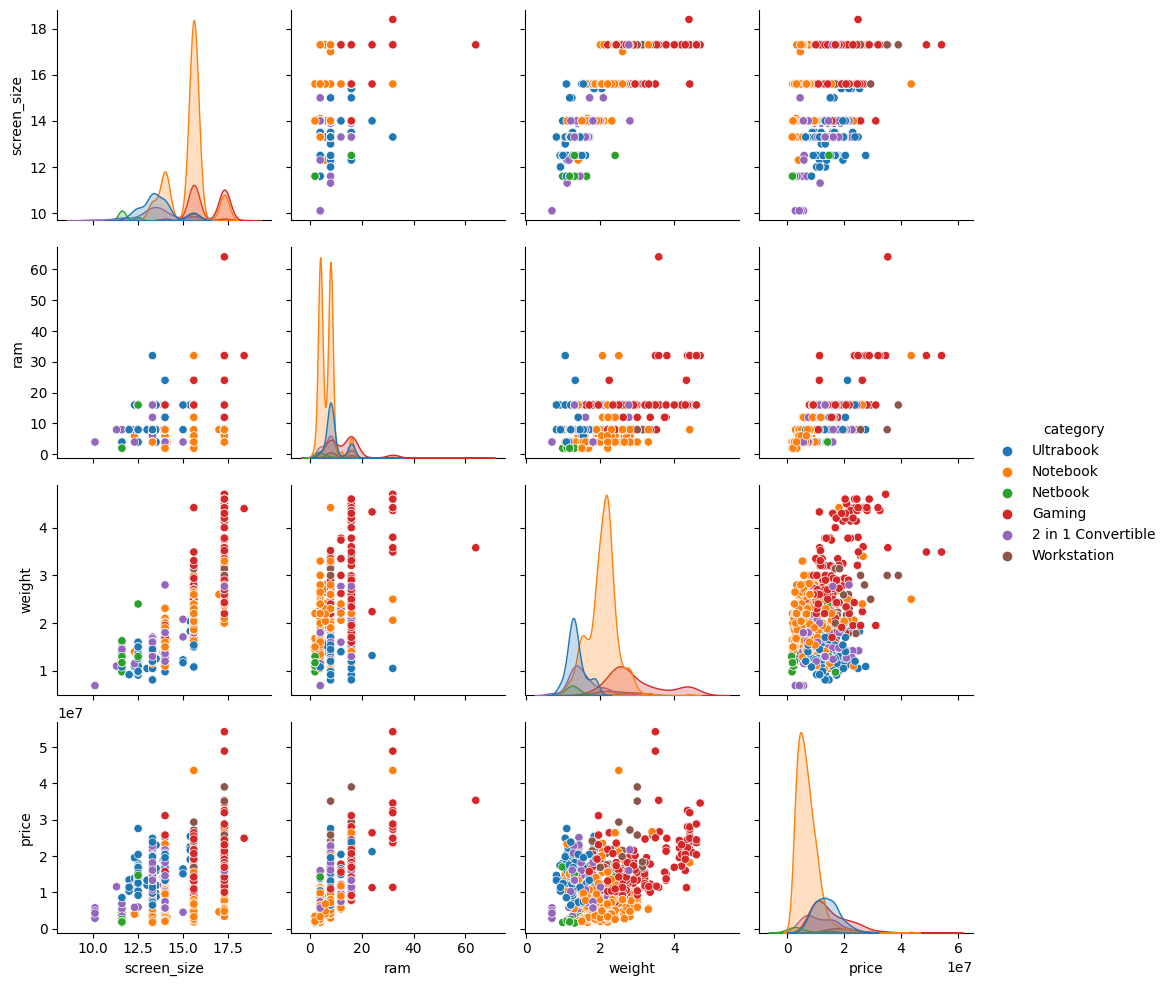

In [58]:
ax = sns.pairplot(data= df, hue= 'category')
plt.show()

## 5.12. Correlation analysys

<Axes: >

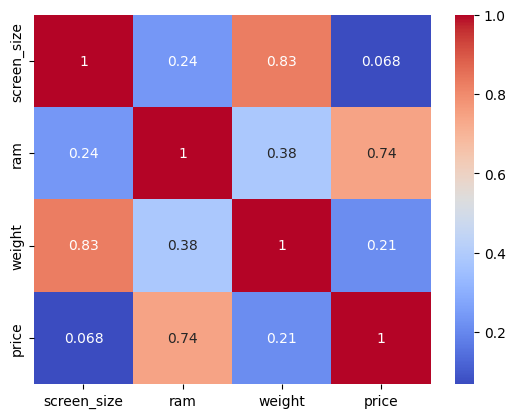

In [59]:
sns.heatmap(data= df.corr(numeric_only= True), annot= True, cmap= 'coolwarm')

> The heatmap shows a high correlation between the independent variables `weight and screen_size`.

To confirm multicollinearity, the Variance Inflation Factor (VIF) is used.

In [60]:
vif = pd.DataFrame()
X = df[['screen_size', 'ram', 'weight']] # only numeric variables.
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

      Variable   VIF
0  screen_size 17.63
1          ram  4.31
2       weight 19.14


> $VIF > 10$ indicates multicollinearity. In this case, enter the variables `weight` and `screen_size`.

# 6. Regression models

## 6.1. Splitting data

In [61]:
# Setting X and y:

X = df.drop(['weight', 'price'], axis= 1) # weight column is dropped to avoid multicollinearity.
y = df['price']

# Splitting in train and test with test size at 30%:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## 6.2. Categorical variable encoding

The main idea behind TargetEncoder is to use information from the label (target) to create a numerical representation that captures the relationship between the categorical variable and the target variable. This can help the model learn more meaningful patterns and improve predictive performance.

In [62]:
# Cols parameter to specific columns that will be encoded:

encoder = TargetEncoder(
    cols= ['manufacturer', 'model_name', 'category', 'screen', 'cpu', 'storage', 'gpu', 'operating_system',	'operating_system_version']
)

In [63]:
# Encoding X train data:

X_train = encoder.fit_transform(X_train, y_train)

# Encoding X test data:

X_test = encoder.transform(X_test)

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


## 6.3. Log transformation

In order to approximate the data to a **normal distribution** and avoid **heteroscedasticity**, a logarithmic transformation of the data is performed.

In [64]:
# Log transformation of X_train and X_test:

X_train = np.log(X_train)
X_test = np.log(X_test)

In [65]:
# Log transformation of y_train and y_test:

y_train = np.log(y_train)
y_test = np.log(y_test)

## 6.4. Training models

The models with their hyperparameters, when these are defined, are contained in a dictionary that can be seen below:

In [66]:
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha= 0.01, max_iter= 100, random_state= 0),
    'Ridge': Ridge(alpha= 1, max_iter= 100, random_state= 0),
    'ElasticNet': ElasticNet(alpha= 0.01, max_iter= 100, random_state= 0)
}

The function below iterates and trains the different models:

In [67]:
def train_models(X_train_data: pd.DataFrame, y_train_data: pd.Series, models_dict: dict):
  """""""""
  X_train: independent variable data for model training.
  y_train: target variable data.
  models: dictionary with models.
  """""""""
  trained_models = dict()  # dictionary that will hold the trained models.

  for model_name, model_config in models.items():
    model_trained = model_config.fit(X_train_data, y_train_data)

    trained_models[model_name] = model_trained # the dictionary keys are the names of the respective models.

  return trained_models

In [68]:
# The models are then trained and instantiated on the variable:

models_trained = train_models(X_train, y_train, models)

In [69]:
models_trained

{'LinearRegression': LinearRegression(),
 'Lasso': Lasso(alpha=0.01, max_iter=100, random_state=0),
 'Ridge': Ridge(alpha=1, max_iter=100, random_state=0),
 'ElasticNet': ElasticNet(alpha=0.01, max_iter=100, random_state=0)}

## 6.5. Predicting values

In [70]:
def predict_values(X: pd.DataFrame, models: dict):
  """""""""
  X: data with independent variables, train data or test data.
  models: dictionary with trained models.
  """""""""
  predicted_values = dict()

  for model_name, model_config in models.items():
    y_predict = model_config.predict(X)
    predicted_values[model_name] = y_predict # the predicted values ​​are stored in a dictionary where the keys are the model names.

  return predicted_values

In [71]:
# Values ​​are predicted, both from the X_test:

predict_values_test = predict_values(X_test, models_trained)

# As well as the X_train:

predict_values_train = predict_values(X_train, models_trained)

## 6.6. Evaluating models

In [72]:
def metrics_dataframe(y: pd.Series, predicted_y: dict):
  """""""""
  y: data with target variable, train data or test data.
  predicted_y: dictionary with predicted values for y from train data or test data.
  """""""""
  models_df = pd.DataFrame()

  for model_name, predict_y in predicted_y.items():
    model_r2_score = r2_score(y, predict_y)
    model_MAE = mean_absolute_error(y, predict_y)
    model_MSE = mean_squared_error(y, predict_y)
    model_RMSE = np.sqrt(mean_squared_error(y, predict_y))

    model_scores_df = pd.DataFrame(
        {'R² score': model_r2_score, 'MAE': model_MAE, 'MSE': model_MSE, 'RMSE': model_RMSE}, index= [model_name]
    ) # dataframe with scores for each model.

    models_df = pd.concat([model_scores_df, models_df]) # all dataframes are concated.

  return models_df

In summary:

* **R-squared:** is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination or the coefficient of multiple determination for multiple regression. The definition of R-squared is quite simple: it is the percentage of variation in the response variable that is explained by a linear model.

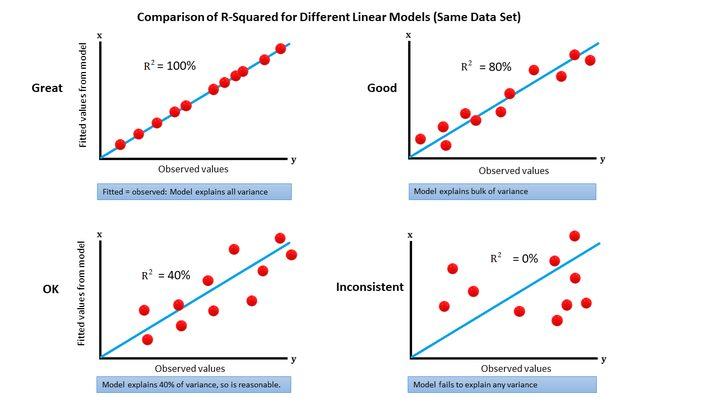

* **Mean absolute error (MAE):** measures the mean of the absolute difference between the values ​​predicted by the model and the observed values.

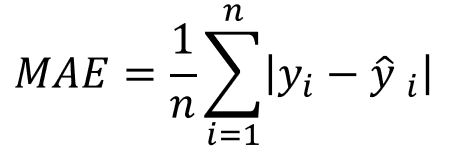

* **Mean squared error (MSE):** measures the amount of error in statistical models. It assesses the average squared difference between the observed and predicted values. When a model has no error, the MSE equals zero. As model error increases, its value increases. The MSE is the average squared distance between the observed and predicted values. Because it uses squared units rather than the natural data units, the interpretation is less intuitive.

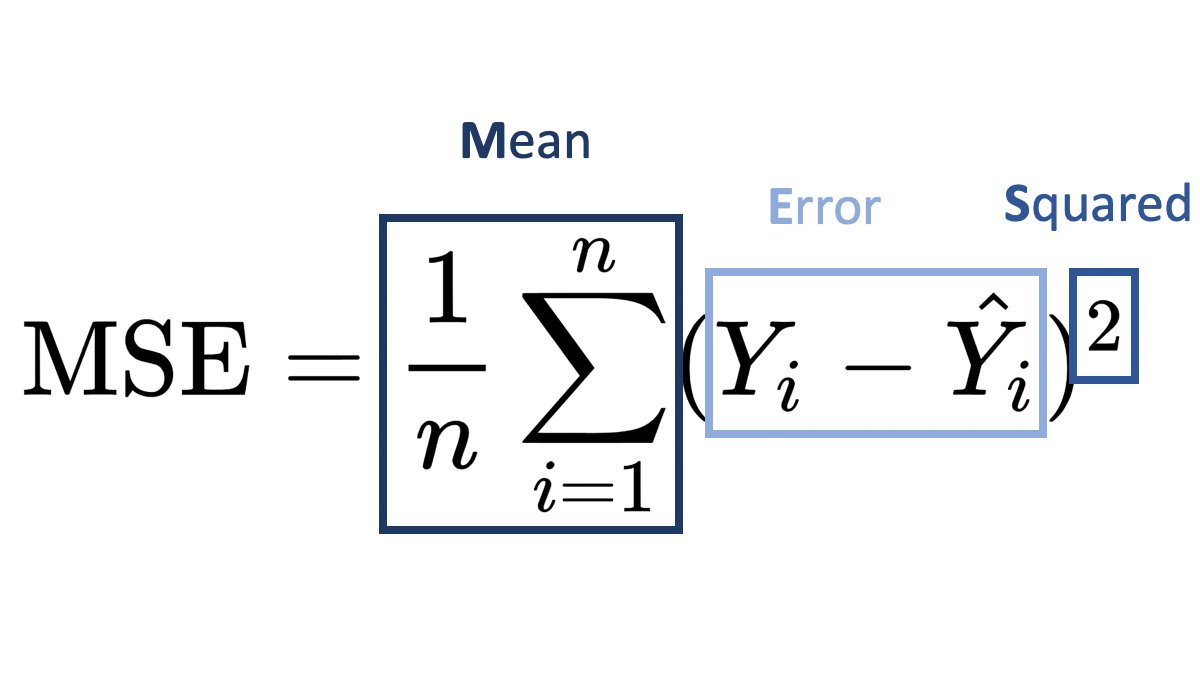

* **Root mean squared error (RMSE):** measures the average difference between a statistical model’s predicted values and the actual values. Mathematically, it is the standard deviation of the residuals. Residuals represent the distance between the regression line and the data points. RMSE quantifies how dispersed these residuals are, revealing how tightly the observed data clusters around the predicted values.

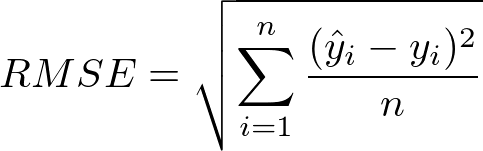


In [73]:
# A dataframe is created with the scores referring to the predicted values ​​from the test data:

scores_dataframe_test = metrics_dataframe((y_test), predict_values_test)

# And another dataframe is instantiated with the scores referring to the predicted values ​​from the training data:

scores_dataframe_train = metrics_dataframe(y_train, predict_values_train)

#### Metrics of predicted values ​​against y_test:

In [74]:
scores_dataframe_test

,R² score,MAE,MSE,RMSE
ElasticNet,0.84,0.19,0.06,0.25
Ridge,0.86,0.18,0.06,0.24
Lasso,0.83,0.20,0.07,0.26
LinearRegression,0.86,0.18,0.06,0.24


#### Metrics of predicted values ​​against y_train:

In [75]:
scores_dataframe_train

,R² score,MAE,MSE,RMSE
ElasticNet,0.87,0.18,0.05,0.23
Ridge,0.88,0.17,0.05,0.22
Lasso,0.86,0.18,0.05,0.23
LinearRegression,0.88,0.17,0.05,0.22


**It is important to remember that, given that the logarithmic transformation of the data was performed, the metrics follow the same scale!**

> When analyzing the metrics obtained with training and test data, there is no great difference between the performance of the models for the two types of data.
> * That is, overfitting is not detected, which is when the model fits too much to the training data, but does not generalize to data that has never been seen (the test data.)

## 6.7. Intercepts and coefficients

* **Intercept:** in linear regression models or intercept represents the expected value of the target variable when the values ​​of all independent variables remain constant. In other words, it is the value at which the regression line touches the y-axis.

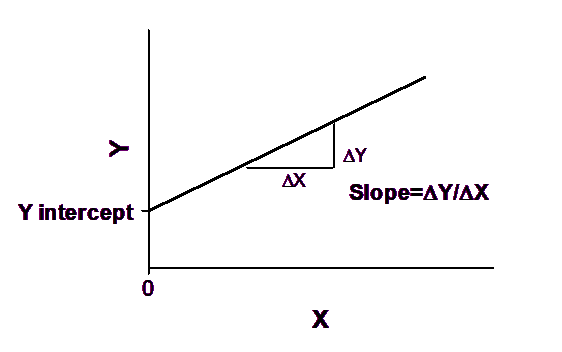

* **Coefficients:** the coefficients in a linear regression model represent the weights assigned to the independent variables to predict the dependent variable.

> Like all data protected by a logarithmic transformation, it is important to note how the coefficients of linear regression models are to be interpreted!
> * **When dependent variable and independent variable are log-transformed:**  interpret the coefficient as the percent increase in the dependent variable for every 1% increase in the independent variable.
>
> Using one of the results obtained below as an example, in the **LinearRegression model**, a **1% increase** in the `ram` variable leads to a **0.23% increase** in the response variable (price).

In [76]:
index = [
    'Intercept', 'manufacturer', 'model_name', 'category', 'screen_size', 'screen',
    'cpu', 'ram', 'storage', 'gpu', 'operating_system', 'operating_system_version'
]

In [77]:
pd.DataFrame({'ElasticNet': np.append(models_trained['ElasticNet'].intercept_, models_trained['ElasticNet'].coef_),
              'Ridge': np.append(models_trained['Ridge'].intercept_, models_trained['Ridge'].coef_),
              'Lasso': np.append(models_trained['Lasso'].intercept_, models_trained['Lasso'].coef_),
              'LinearRegression': np.append(models_trained['LinearRegression'].intercept_, models_trained['LinearRegression'].coef_)},
              index= index)

,ElasticNet,Ridge,Lasso,LinearRegression
Intercept,-7.83,-15.84,-5.40,-16.63
manufacturer,0.09,0.16,0.02,0.16
model_name,0.31,0.28,0.32,0.28
category,0.11,0.11,0.09,0.10
screen_size,-0.00,-0.42,-0.00,-0.48
screen,0.10,0.11,0.08,0.11
cpu,0.29,0.28,0.30,0.28
ram,0.19,0.22,0.19,0.23
storage,0.27,0.25,0.28,0.25
gpu,0.20,0.22,0.20,0.23


## 6.8 Dispersion of predicted values ​​and fit on the line

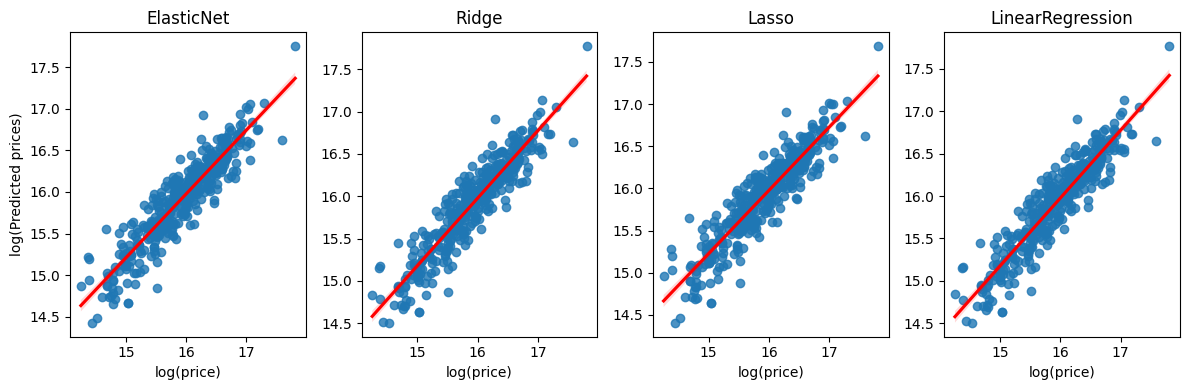

In [78]:
fig, ax = plt.subplots(1, 4, figsize= (12, 4))

ax1 = sns.regplot(x= y_test, y= predict_values_test['ElasticNet'], line_kws= dict(color= 'red'), ax= ax[0])
ax1.set_title('ElasticNet')
ax1.set_ylabel('log(Predicted prices)')
ax1.set_xlabel('log(price)')
ax2 = sns.regplot(x= y_test, y= predict_values_test['Ridge'], line_kws= dict(color= 'red'), ax= ax[1])
ax2.set_title('Ridge')
ax2.set_xlabel('log(price)')
ax3 = sns.regplot(x= y_test, y= predict_values_test['Lasso'], line_kws= dict(color= 'red'), ax= ax[2])
ax3.set_title('Lasso')
ax3.set_xlabel('log(price)')
ax4 = sns.regplot(x= y_test, y= predict_values_test['LinearRegression'], line_kws= dict(color= 'red'), ax= ax[3])
ax4.set_title('LinearRegression')
ax4.set_xlabel('log(price)')
plt.tight_layout()
plt.show()

> The models show a good fit to the line, with more dispersed data in lower and higher log(price) values.

## 6.9 Residual analysis

Residual analysis is important, as a linear regression model must satisfy some assumptions:

* **1. Linear relationship between the dependent and independent variables.**
* **2. No multicollinearity.**
* **3. Residuals must be normally distributed.**
* **4. No heteroskedasticity, the variance of residuals must be constant.**

The first two assumptions have already been addressed, leaving only the last two.

In [79]:
# Residuals

elasticnet_residual = y_train - predict_values_train['ElasticNet']
ridge_residual = y_train - predict_values_train['Ridge']
lasso_residual = y_train - predict_values_train['Lasso']
linearregression_residual = y_train - predict_values_train['LinearRegression']

Remembering that the data underwent a logarithmic transformation, that is, **the residuals are also on a logarithmic scale!**

### Are residuals normally distributed?

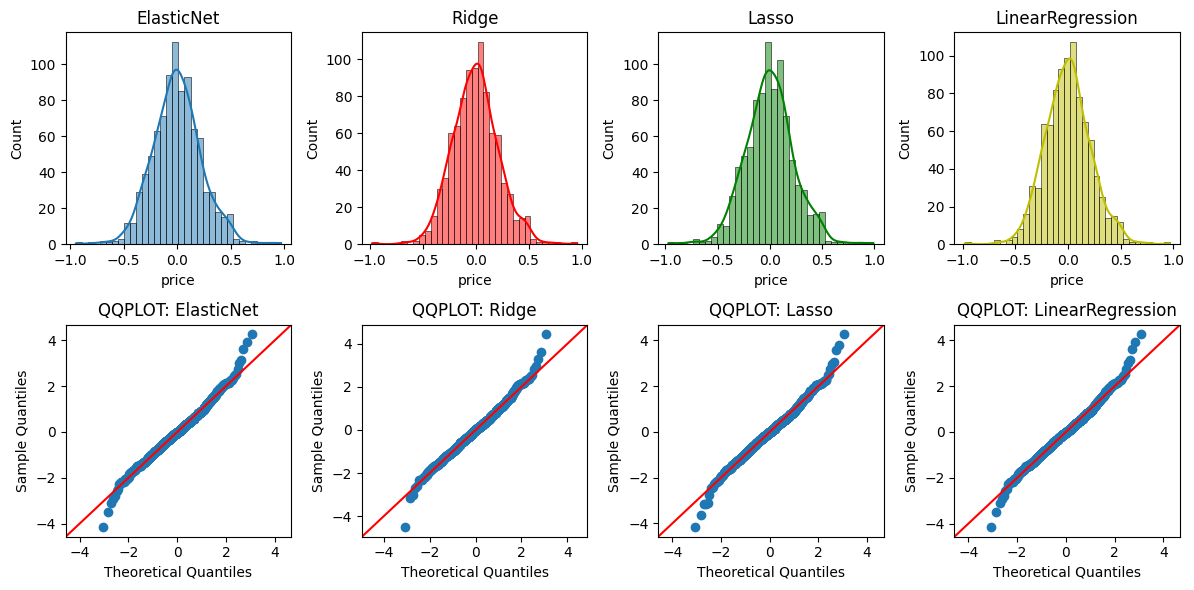

In [80]:
fig, ax = plt.subplots(2, 4, figsize= (12, 6))

ax1 = sns.histplot(elasticnet_residual, kde= True, ax= ax[0, 0])
ax1.set_title('ElasticNet')
ax2 = sns.histplot(ridge_residual, kde= True, color= 'r', ax= ax[0, 1])
ax2.set_title('Ridge')
ax3 = sns.histplot(lasso_residual, kde= True, color= 'g', ax= ax[0, 2])
ax3.set_title('Lasso')
ax4 = sns.histplot(linearregression_residual, kde= True, color= 'y', ax= ax[0, 3])
ax4.set_title('LinearRegression')
sm.qqplot(elasticnet_residual, fit= True, line= '45', ax= ax[1, 0])
ax[1, 0].set_title('QQPLOT: ElasticNet')
sm.qqplot(ridge_residual, fit= True, line= '45', ax= ax[1, 1])
ax[1, 1].set_title('QQPLOT: Ridge')
sm.qqplot(lasso_residual, fit= True, line= '45', ax= ax[1, 2])
ax[1, 2].set_title('QQPLOT: Lasso')
sm.qqplot(elasticnet_residual, fit= True, line= '45', ax= ax[1, 3])
ax[1, 3].set_title('QQPLOT: LinearRegression')
plt.tight_layout()

> All models present residuals with a distribution close to the normal distribution.

### Checking heteroskedasticity

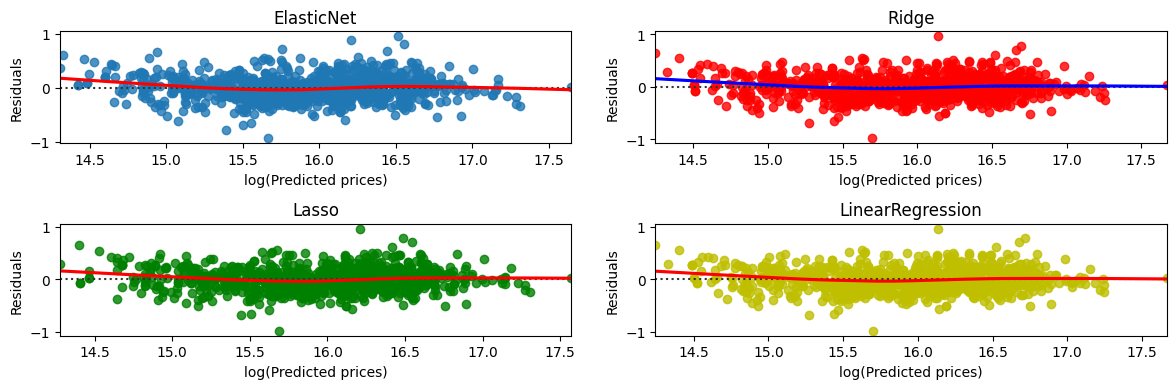

In [81]:
fig, ax = plt.subplots(2, 2, figsize= (12, 4))

ax1 = sns.residplot(x= predict_values_train['ElasticNet'], y= elasticnet_residual, lowess= True, line_kws= dict(color= 'red'), ax= ax[0, 0])
ax1.set_title('ElasticNet')
ax1.set_ylabel('Residuals')
ax1.set_xlabel('log(Predicted prices)')
ax2 = sns.residplot(x= predict_values_train['Ridge'], y= ridge_residual, color= 'r', lowess= True, line_kws= dict(color= 'blue'), ax= ax[0, 1])
ax2.set_title('Ridge')
ax2.set_ylabel('Residuals')
ax2.set_xlabel('log(Predicted prices)')
ax3 = sns.residplot(x= predict_values_train['Lasso'], y= ridge_residual, color= 'g', lowess= True, line_kws= dict(color= 'red'), ax= ax[1, 0])
ax3.set_title('Lasso')
ax3.set_ylabel('Residuals')
ax3.set_xlabel('log(Predicted prices)')
ax4 = sns.residplot(x= predict_values_train['LinearRegression'], y= ridge_residual, color= 'y', lowess= True, line_kws= dict(color= 'red'), ax= ax[1, 1])
ax4.set_title('LinearRegression')
ax4.set_ylabel('Residuals')
ax4.set_xlabel('log(Predicted prices)')
plt.tight_layout()
plt.show()

> For all models the variance of the residuals is constant for almost all predicted values. That is, it approaches a homoscedastic behavior.

# 7. Conclusion

The following tasks were performed on this notebook:

* **1. Analysis of dataframe information, as well as checking for missing values.**
* **2. Some small treatments in the dataframe like renaming the columns, changing the data types of the variables and imputing where there were missing values.**
* **3. Exploratory data analysis.**
* **4. Data preprocessing using TargetEncoder on categorical variables and data logarithmic transformation.**
* **5. Training of the ElasticNet, Ridge, Lasso and LinearRegression models and subsequent evaluation of the models (R², MAE, MSE and RMSE).**
* **6. Residual analysis, checking the distribution of residuals and whether there is heteroskedasticity.**